In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
from tqdm.notebook import trange
import random
from sklearn.metrics import f1_score,mean_absolute_error
from tensorflow.keras.datasets.boston_housing import load_data
from sklearn.preprocessing import MinMaxScaler
import glob

In [2]:
!wget https://github.com/vlsantos-bit/LSTM-Neural/archive/master.zip

--2020-07-01 02:04:50--  https://github.com/vlsantos-bit/LSTM-Neural/archive/master.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vlsantos-bit/LSTM-Neural/zip/master [following]
--2020-07-01 02:04:50--  https://codeload.github.com/vlsantos-bit/LSTM-Neural/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ]   4.57M  6.68MB/s    in 0.7s    

2020-07-01 02:04:53 (6.68 MB/s) - ‘master.zip’ saved [4794846]



In [3]:
!unzip master.zip

Archive:  master.zip
59c5a8f1e952d801af1b851535814353c31161be
   creating: LSTM-Neural-master/
  inflating: LSTM-Neural-master/README.md  
  inflating: LSTM-Neural-master/dado_INMET.csv  


In [4]:
# Realizando a abertura dos dados 
df = pd.read_csv("LSTM-Neural-master/dado_INMET.csv", delimiter=";",quotechar='"', decimal=".")
# Selecionando várivél 
pres=df['PRES']
# Limpando os valores nan 
pressu=pres.replace([np.inf, -np.inf,'-9999.0',-9999.0], np.nan)
pres1=pd.DataFrame(pressu).dropna()
# Passando os valores para uma matriz
pre = np.array(pres1)
pre

array([[1013.9],
       [1014.4],
       [1013.8],
       ...,
       [1000.3],
       [1000.8],
       [1000.2]])

valor maximo [1032.]
valor minimo [988.7]
numero de valores não coletados 5357


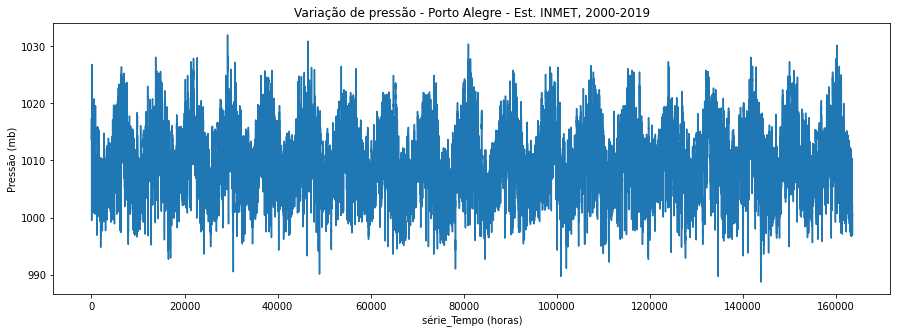

In [5]:
# Plotando os resultados, valores máximos e mínimos e valores descartados 
plt.figure(figsize = (15, 5))
plt.plot(pre[:])
print('valor maximo',max(pre))
print('valor minimo',min(pre))
plt.xlabel("série_Tempo (horas)")
plt.ylabel("Pressão (mb)")
plt.title("Variação de pressão - Porto Alegre - Est. INMET, 2000-2019")
print('numero de valores não coletados',pres.size-len(pre))

In [6]:
#normalizando dado
pre=np.reshape(pre,(len(pre),1))
scaler = MinMaxScaler(feature_range = (-1, 1))
dado_normalizado = scaler.fit_transform(pre)
dado_normalizado.shape

(163599, 1)

In [7]:
#normalizando dado
n=int(len(dado_normalizado)*0.3)
pres_train=dado_normalizado[:-n]
pres_test=dado_normalizado[-n:]
pres_train.shape

(114520, 1)

In [8]:
x_train=[]
y_train=[]

# Estruturando o sistema de entrada do conjunto de treinamento e o conjunto de teste
for i in range(6,len(pres_train)-1):
    x_train.append(pres_train[i-6:i])
    y_train.append(pres_train[i][0])
x_train=np.array(x_train)
y_train=np.array(y_train)
#################################################
x_test=[]
y_test=[]
for i in range(6,len(pres_test)-1):
    x_test.append(pres_test[i-6:i])
    y_test.append(pres_test[i][0])
x_test=np.array(x_test)
y_test=np.array(y_test)
x_test.shape

(49072, 6, 1)

In [9]:
# Criando os parâmetros da rede
def fit_model(x_train,y_train):
    model = Sequential()
    model.add(LSTM(50, activation='relu',input_shape=(6,1)))
    model.add(Dense(1))
    model.compile(loss = "mse", optimizer = "Adam",metrics=["accuracy"])
    model.fit(x_train,y_train, epochs = 100, batch_size = 100, verbose = 1)
    return(model)

In [10]:
# Treinando a rede 

modelo = fit_model(x_train,y_train)

Epoch 1/100
1146/1146 [==============================] - 14s 12ms/step - loss: 0.0023 - accuracy: 8.7326e-06
Epoch 2/100
1146/1146 [==============================] - 13s 12ms/step - loss: 6.8451e-04 - accuracy: 8.7326e-06
Epoch 3/100
1146/1146 [==============================] - 14s 12ms/step - loss: 6.5279e-04 - accuracy: 8.7326e-06
Epoch 4/100
1146/1146 [==============================] - 13s 11ms/step - loss: 6.4282e-04 - accuracy: 8.7326e-06
Epoch 5/100
1146/1146 [==============================] - 13s 12ms/step - loss: 6.2880e-04 - accuracy: 8.7326e-06
Epoch 6/100
1146/1146 [==============================] - 13s 12ms/step - loss: 6.2480e-04 - accuracy: 8.7326e-06
Epoch 7/100
1146/1146 [==============================] - 14s 12ms/step - loss: 6.2138e-04 - accuracy: 8.7326e-06
Epoch 8/100
1146/1146 [==============================] - 13s 12ms/step - loss: 6.1262e-04 - accuracy: 8.7326e-06
Epoch 9/100
1146/1146 [==============================] - 13s 11ms/step - loss: 6.1346e-04 - accuracy

In [15]:
#Função de criação do score do modelo
def predict_and_score(modelo, X, Y):
    # realizando a previsão e desnomalizando os dados.
    pred = scaler.inverse_transform(modelo.predict(X))
    orig_data = scaler.inverse_transform([Y])
    # Calculando o erro médio quadrado
    score = math.sqrt(mean_squared_error(orig_data[0,:], pred[:,0]))
    return(score, pred)

In [16]:
import math
from sklearn.metrics import mean_squared_error


In [17]:
#Calculando os erros médios quadrados
rmse_train, train_predict = predict_and_score(modelo, x_train, y_train)
rmse_test, test_predict = predict_and_score(modelo, x_test, y_test)
real=scaler.inverse_transform(dado_normalizado)
print("score dados de teste: %.2f RMSE" % rmse_test)
print("score dados de treinamento: %.2f RMSE" % rmse_train)

score dados de teste: 0.50 RMSE
score dados de treinamento: 0.50 RMSE


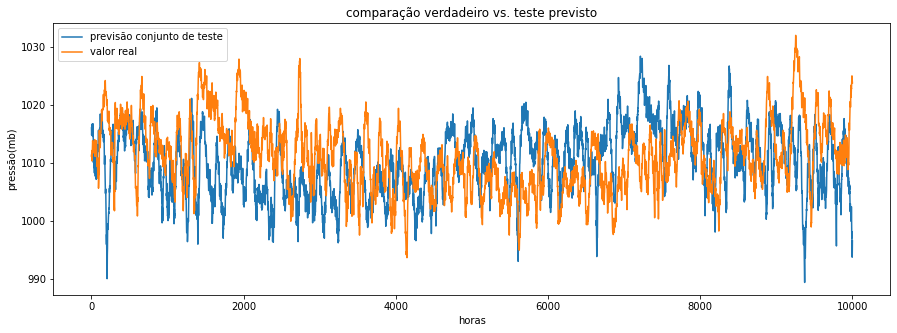

In [18]:
#Plotando os resultados
plt.figure(figsize = (15, 5))
#plt.plot(train_predict[40000:50000], label= "previsão conjunto de treinamento")
plt.plot(test_predict[20000:30000], label="previsão conjunto de teste")
plt.plot(real[20000:30000],label="valor real")
plt.xlabel("horas")
plt.ylabel("pressão(mb)")
plt.title("comparação verdadeiro vs. teste previsto")
plt.legend()
plt.show()

Text(0.5, 1.0, 'distribuição dos resultados')

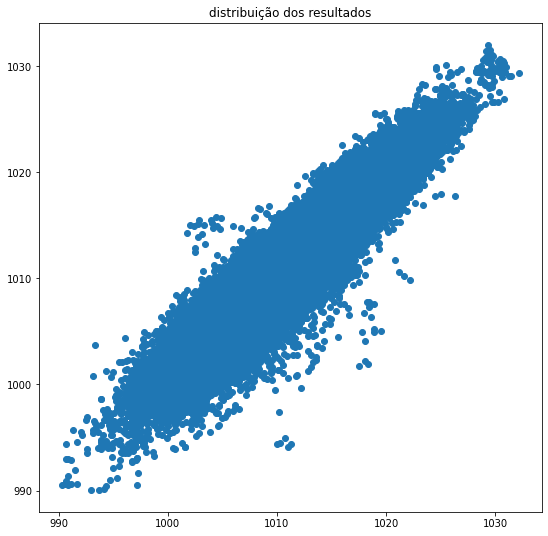

In [22]:
#Plotando distribuição dos resultados

plt.figure(figsize = (9, 9))
x = np.array(train_predict[0:49072])
y = np.array(real[0:49072])
plt.scatter(x,y)
plt.title("distribuição dos resultados")
